### exploring data

In [663]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

In [664]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [665]:
df_b = pd.read_csv("basel.csv", index_col=0)
df_b.head()

,datetime,et,p,t,obs
0,1981-01-01,0.000405,0.003536,-0.250816,670.0
1,1981-01-02,0.000472,0.003379,2.172385,647.0
2,1981-01-03,0.000576,0.017352,5.165919,727.0
3,1981-01-04,0.000443,0.022734,1.019687,1363.0
4,1981-01-05,0.000364,0.005195,-2.055391,1202.0


In [622]:
# how do you normalise the temperature var?
# x = df_b.t.values
#
# B = np.reshape(x, (-1, 1))
# B.shape
# scaler = MinMaxScaler()
# normalised  = scaler.fit_transform(B)
# normalised.max()


In [623]:
# df_b["normalized_t"] = normalised
# df_b.loc[df_b.t ==-21.92899]

In [624]:
df_b.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
et,7305.0,0.001714,0.001106,0.000174,0.000699,0.001463,0.002551,0.005657
p,7305.0,0.004003,0.006059,0.000000,0.000000,0.001118,0.005937,0.064737
t,7305.0,7.407180,7.137879,-21.928990,2.108310,7.466198,13.141790,25.095398
obs,7305.0,1089.771141,460.346002,393.000000,751.000000,1003.000000,1332.000000,4583.996000


In [625]:
q_basel = pd.read_csv("q_basel.csv")
q_basel = q_basel.drop(["obs"], axis =1)
q_basel = q_basel.set_index("datetime")
q_basel

,pcr,res
datetime,,
1981-01-01,605.06915,64.93085
1981-01-02,599.35767,47.64233
1981-01-03,874.38354,-147.38354
1981-01-04,998.86804,364.13196
1981-01-05,968.06270,233.93730
...,...,...
2000-12-27,1055.62610,-393.59110
2000-12-28,1027.90730,-371.65430
2000-12-29,860.76306,-208.61306


In [626]:
# y_sample_2

In [627]:
# is it the right thing to do?
# shouldnot I make day and month vars with it?
df_basel = df_b.set_index("datetime")
df_basel.shape

(7305, 4)

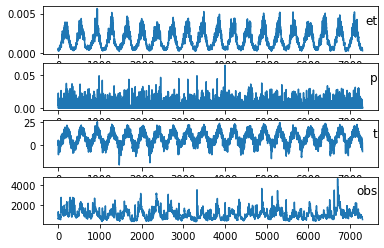

In [628]:
from matplotlib import pyplot
values = df_basel.values

# specify columns to plot
groups =[0,1,2,3]
i=1
# plot each column
pyplot.figure()
for g in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, g])
    pyplot.title(df_basel.columns[g], y= 0.5, loc ="right")
    i += 1
pyplot.show()



### LSTM data prepration

In [629]:
# a function that, given the initial dataframe, return a shorter dataframe sequence of length.
# This shorter sequence should be selected at random.
def subsample_sequence(df, length):

    last_possible = df.shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]

    return df_sample

In [630]:
# a function to deal with nan values
def fillna(X, df_mean):

    na = X.mean()

    na.fillna(df_mean)
    return na

# a function that given a full dataframe, first subsample this dataset into a shorter sequence,
# and then splits the shorter dataframe into a training sequence and a value to predict.

def split_subsample_sequence(df, length, df_mean=None):
    # Little trick to improve the time
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    if set(["pcr","res"]).issubset(df_subsample.columns):
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['pcr']
    else:
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['obs']

    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(df, length, df_mean)
        return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:df_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, df_mean))
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [631]:
# another function that generates an entire dataset of multiple subsamples,
# given an initial dataframe df, a number of desired sequences, and a length for each sequence

def get_X_y(df, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [632]:
# train test split
len_ = int(0.7*df_basel.shape[0])

df_train = df_basel[:len_]
df_test = df_basel[len_:]

In [633]:
# time window has to be decided later but for now I keep it 50

# X_train, y_train = get_X_y(df_train, 2000, 121) # The training set correspond to 1000 sequences, each of size 50 (+ the time to predict)
# X_test, y_test = get_X_y(df_test, 731, 121)

# how to decide about number of sequence and time window?

In [634]:
# print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

In [635]:
# X_train[0]  # drop column 4 for each array

In [636]:
# y_train

In [637]:
# dropping "obs" var from predictors in train set
# X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
# X_train_ready = np.asarray(X_train_new)
# X_train_ready.shape

In [638]:
# dropping "obs" var from predictors in test set
# X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
# X_test_ready = np.asarray(X_test_new)
# X_test_ready.shape

### Normalize data

In [639]:
# https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
# X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)
#
# X_test_scaled[0]

In [640]:
# # normalize output
# y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))
#
# scaler = MinMaxScaler()
# y_train_scaled = scaler.fit_transform(y_train_shaped)
# # y_train_scaled[0]
#
# y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))
#
# y_test_scaled = scaler.transform(y_test_shaped)
# y_test_scaled.shape

### Build the model

In [641]:
#!pip install hydroeval

In [642]:
# do I have to normalise the output varibale as well? for a regression using LSTM-RNN, you need to de-normalize outputs once again in the final layer.
#  for a regression using LSTM-RNN, you need to de-normalize outputs once again in the final layer.

# https://www.quora.com/Do-I-have-to-normalize-the-output-variables-also-when-Im-normalizing-input-variables-for-gradient-descent
# https://datascience.stackexchange.com/questions/24214/why-should-i-normalize-also-the-output-data


# undertanding lstm input shape
# https://localcoder.org/understanding-lstm-input-shape-in-keras-with-different-sequence
# you can just not specify input shape argument in model and see what happens

In [643]:
# https://wandb.ai/lavanyashukla/visualize-models/reports/How-to-stack-multiple-LSTMs-in-keras---VmlldzoxOTg2MTY

In [644]:
%%time
# from numpy.random import seed
# seed(1)
# tf.random.set_seed(1234)

def init_model():

    model = models.Sequential()
    model.add(layers.LSTM(100, activation='relu', return_sequences=True)) # input shape?? input_shape =(X_train_scaled.shape[1],3)
    model.add(Dropout(0.1)) # decrease this
    model.add(layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    model.add(layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.1))
    model.add(layers.LSTM(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1,activation='linear')) # activation = linear # maybe no need to y scaled : if I dont normalise it, I get very high val_mae


    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'])

    return model

from tensorflow.keras.callbacks import EarlyStopping

# model = init_model()
#
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)
#
# history = model.fit(X_train_scaled, y_train_scaled,
#             validation_data=(X_test_scaled, y_test_scaled), # try validation_split=0.2
#             epochs=1000,
#             batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
#             callbacks=[es])

Wall time: 0 ns


In [645]:
# print(model.input_shape, model.output_shape) # None is a placeholder of batch size

In [646]:
# model.summary()

In [647]:
# res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
#
# print(f'MSE on the test set : {res[1]:.4f}')

In [648]:
# plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

In [649]:
# import hydroeval as he
# y_pred = model.predict(X_test_scaled)
#
# nse = he.evaluator(he.nse,y_pred,y_test_scaled)
# nse[0]


In [650]:

# kge = he.evaluator(he.kge, y_pred, y_test_scaled)
# kge[0]

In [651]:
def train_multiple_times():
    # run_scores_nse = list()
    # run_scores_kge = list()
    # for i in range(repeats):
    X_train, y_train = get_X_y(df_train, 1000, 141)
    X_test, y_test = get_X_y(df_test, 365, 141)

    # processing data
    X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
    X_train_ready = np.asarray(X_train_new)
    X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
    X_test_ready = np.asarray(X_test_new)

    # transforming input
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
    X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)

    # transforming output
    y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train_shaped)
    y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))
    y_test_scaled = scaler.transform(y_test_shaped)

    model = init_model() # first defined model above

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    model.fit(X_train_scaled, y_train_scaled,
                validation_split=0.2,
                epochs=1000,
                batch_size=32,
                callbacks=[es],
                verbose=1)

    y_pred = model.predict(X_test_scaled)

    nse = he.evaluator(he.nse,y_pred,y_test_scaled)
    kge = he.evaluator(he.kge, y_pred, y_test_scaled)
    # run_scores_nse.append(nse)
    # run_scores_kge.append(kge)
    return (nse[0],kge[0])

In [652]:
%%time

# # do the for loop out of function

nse = []
kge = []
repeats = [1, 2, 3, 4, 5, 6, 7 , 8 , 9 , 10, 11, 12]

for t in repeats:

    nse_train, kge_train = train_multiple_times()
    nse.append(nse_train)
    kge.append(kge_train)

    print(f'For {t} time running model, the NSE is : {nse_train}')
    print(f'For {t} time running model, the KGE is : {kge_train}')

Epoch 1/1000
25/25 [==============================] - 16s 448ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 2/1000
25/25 [==============================] - 11s 425ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 3/1000
25/25 [==============================] - 11s 433ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 4/1000
25/25 [==============================] - 11s 433ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/1000
25/25 [==============================] - 11s 446ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 6/1000
25/25 [==============================] - 12s 492ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 7/1000
25/25 [==============================] - 12s 473ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 8/1000
25/25 [==============================] - 1

In [653]:
nse = np.array(nse)

In [654]:
kge

[array([0.74716148]),
 array([0.62832048]),
 array([0.80794842]),
 array([0.71961759]),
 array([nan]),
 array([0.59267434]),
 array([0.77599784]),
 array([nan]),
 array([0.73575151]),
 array([0.59046364]),
 array([0.78069296]),
 array([0.75550691])]

In [655]:
np.save('nse_basel_3.npy', nse, allow_pickle=True)


In [656]:
nse_loaded = np.load('nse_basel_3.npy',allow_pickle=True)
np.nanmean(nse_loaded)

0.6874900208691268

In [657]:
np.save('kge_basel_3.npy', kge, allow_pickle=True)


In [658]:
kge_loaded = np.load('kge_basel_3.npy',allow_pickle=True)
np.nanmean(kge_loaded)

0.7134135189877142

In [659]:
# repeats = range(2)
# run_scores_nse = list()
# run_scores_kge = list()
# for i in repeats:
#     history = model.fit(X_train_scaled, y_train_scaled,
#             validation_data=(X_test_scaled, y_test_scaled), # try validation_split=0.2
#             epochs=2,
#             batch_size= 32,
#             callbacks=[es])
#     y_pred = model.predict(X_test_scaled)
#
#     nse = he.evaluator(he.nse,y_pred,y_test_scaled)
#     kge = he.evaluator(he.kge, y_pred, y_test_scaled)
# run_scores_nse.append(nse)
# run_scores_kge.append(kge)

In [660]:
# run_scores_nse

In [407]:
# https://machinelearningmastery.com/evaluate-skill-deep-learning-models/
# repeats = range(10)
# scores_nse = list()
# for i in repeats:
# 	run_scores_nse = list()
#     run_scores_kge = list()
# 	for j in k:
#         history = model.fit(X_train_scaled, y_train_scaled,
#             validation_data=(X_test_scaled, y_test_scaled), # try validation_split=0.2
#             epochs=1000,
#             batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
#             callbacks=[es])
#         y_pred = model.predict(X_test_scaled)
#
#         nse = he.evaluator(he.nse,y_pred,y_test_scaled)
#         kge = he.evaluator(he.kge, y_pred, y_test_scaled)
#
# 		run_scores_nse.append(nse)
#         run_scores_kge.append(kge)
# 	scores.append(mean(run_scores_nse))
#     scores.append(mean(run_scores_kge))

In [262]:
# first run  nse = 0.80  kge = 0.80
# second run nse = 0.76 kge = 0.69
# third run nse = 0.79 kge = 0.75
# fourth run nse =0.74 kge = 0.75
# fifth run nse = 0.73, kge = 0.77
# six run nse = 0.65, kge = 0.68
# seventh run nse = 0.74, kge = 0.71
# eights run nse = 0.78, kge = 0.79
# ninth run  0.75, kge = 0.75
# tenth run nse = 0.74, kge = 0.72

## Prediction

In [263]:
# https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

train_predict = model.predict(X_train_scaled)
test_predict = model.predict(X_test_scaled)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(y_train_scaled) # make it a list
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(y_test_scaled)


In [661]:
#test_predict

## Plot

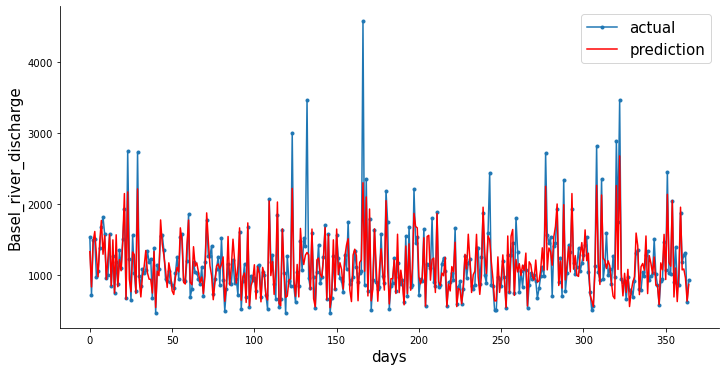

In [265]:
# comparing actual and predicted values for the last 356 days
import seaborn as sns

aa=[x for x in range(365)]
plt.figure(figsize=(10,5))
plt.plot(aa, Y_test[:365], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:365], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [266]:
# https://stackoverflow.com/questions/43702481/why-does-keras-lstm-batch-size-used-for-prediction-have-to-be-the-same-as-fittin :Why does Keras LSTM batch size used for prediction have to be the same as fitting batch size?

# getting the result of pcr model
pcr_pred = q_basel.pcr.values

# train-test split
len_ = int(0.8*q_basel.shape[0])

df_train_pcr = q_basel[:len_]
df_test_pcr = q_basel[len_:]

# making data in right shape
pcr_X_train, pcr_y_train = get_X_y(df_train_pcr, 2000, 151)
pcr_X_test, pcr_y_test = get_X_y(df_test_pcr, 731, 151)

# normalize pcr_observation
pcr_y_test_reshaped = np.reshape(pcr_y_test, (pcr_y_test.shape[0], 1))

scaler = MinMaxScaler()
pcr_y_test_scaled = scaler.fit_transform(pcr_y_test_reshaped)

# nse for pcr
nse_pcr = he.evaluator(he.nse, pcr_y_test_scaled, y_test_scaled)
nse_pcr

array([-0.63366666])

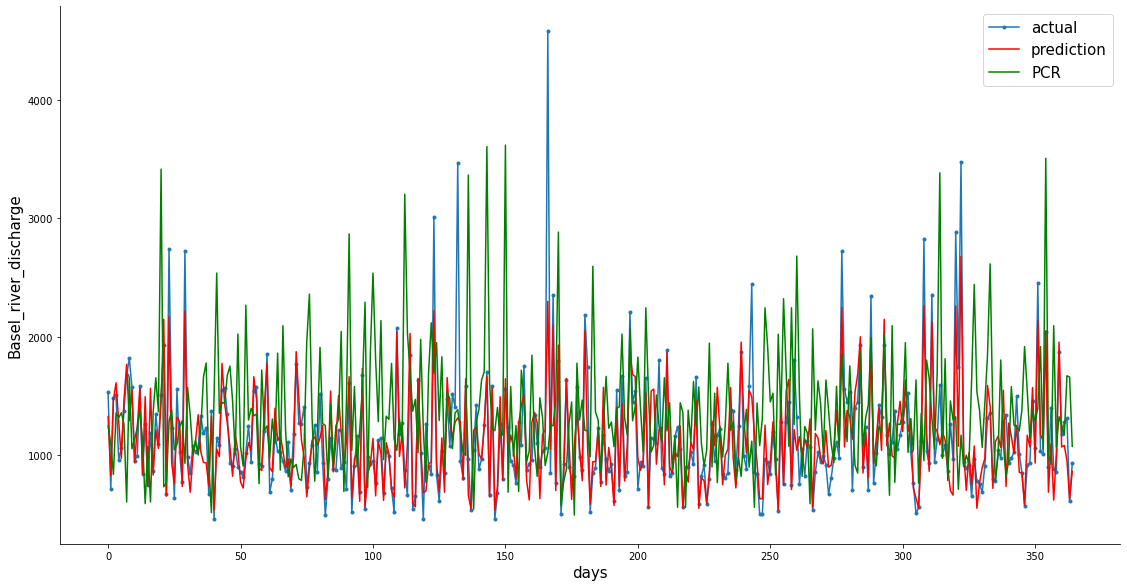

In [267]:
aa=[x for x in range(365)]
plt.figure(figsize=(16,8))
plt.plot(aa, Y_test[:365], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:365], 'r', label="prediction")
plt.plot(aa, pcr_y_test [:365], "green", label ="PCR" )
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [268]:
#define a smoothing function
def smooth_fun(y, window):
  new_len = len(y)//window
  smooth_y = np.zeros((new_len))
  for i in range(new_len):
    smooth_y[i] = np.mean(y[i*window:i*window+window])
  return smooth_y

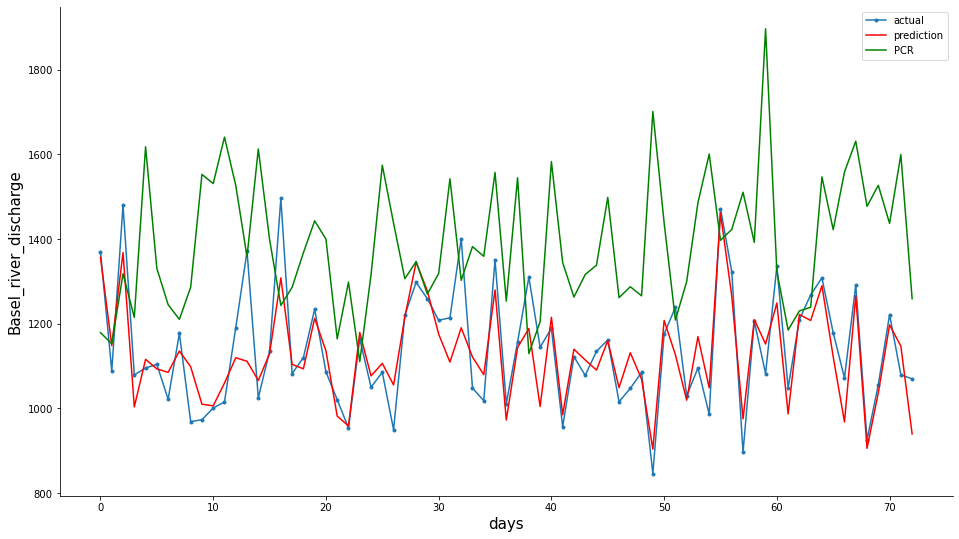

In [269]:
#plot smoothed predictions
plt.figure(figsize = (16,9))
plt.plot(smooth_fun(Y_test, 10),marker='.', label = "actual")
plt.plot(smooth_fun(test_predict, 10),"r", label = "prediction")
plt.plot(smooth_fun(pcr_y_test,10),"g", label = "PCR")
plt.ylabel('Basel_river_discharge', size=15)
plt.xlabel('days', size=15)
sns.despine(top=True)
# plt.subplots_adjust(left=0.07)

plt.legend()
plt.show()

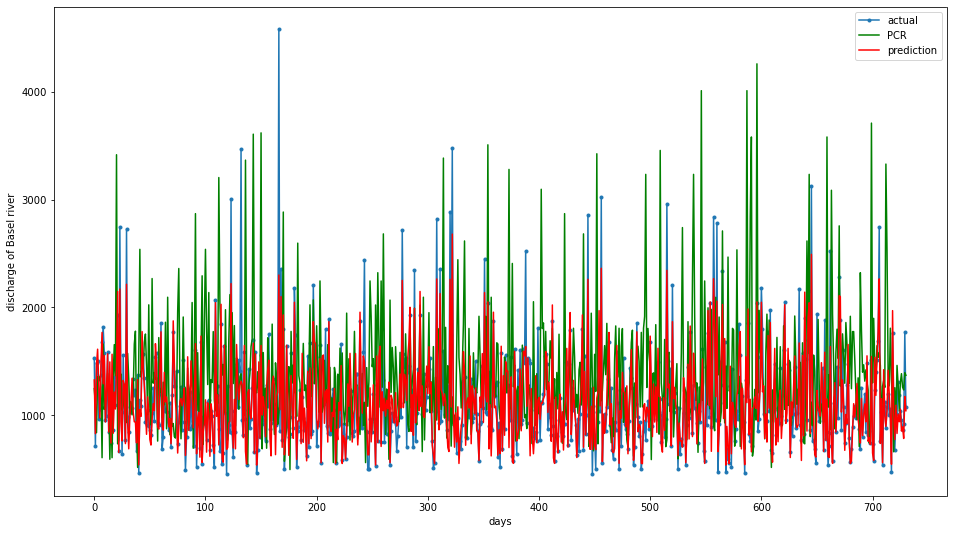

In [270]:
# make a plot of observed dicharge, prediction of model, prediction of pcr for the last 2 years
# plot it agianst date but you can take the last two years

# discharge_date = df_basel['1999-01-01':'2000-12-31']
#
# discharge_observed = discharge_date.obs.values # shouldnot it be Y_test
#
# discharge_pcr_date = q_basel['1999-01-01':'2000-12-31']
# discharge_pcr = discharge_pcr_date.pcr.values  # shouldnot it be pcr_y_test

# plt.figure(figsize=(16,9))
# plt.plot(discharge_observed, marker='.', label="actual")
# plt.plot(discharge_pcr, 'r', label="PCR")
# plt.xlabel('days')
# plt.ylabel('discharge of Basel river')
# plt.plot(test_predict, 'green', label="prediction")
# plt.legend()

plt.figure(figsize=(16,9))
plt.plot(Y_test[:731], marker='.', label="actual")
plt.plot(pcr_y_test [:731], 'green', label="PCR")
plt.plot(test_predict, 'r', label="prediction")
plt.xlabel('days')
plt.ylabel('discharge of Basel river')
plt.legend()

In [662]:
#test_predict

In [272]:
print(y_pred.shape, y_test_scaled.shape)

(731, 1) (731, 1)


## training a simpler model

In [273]:
%%time
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

def init_model_2():

    model = models.Sequential()
    model.add(layers.LSTM(50, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(50, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1,activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'])

    return model

model_2 = init_model_2()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history_2 = model_2.fit(X_train_scaled, y_train_scaled,
            validation_data=(X_test_scaled, y_test_scaled),   # you can also have validation_split
            epochs=1000,
            batch_size=32,
            callbacks=[es])


Epoch 1/1000
47/47 [==============================] - 12s 140ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 2/1000
47/47 [==============================] - 6s 130ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 3/1000
47/47 [==============================] - 6s 131ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 4/1000
47/47 [==============================] - 6s 127ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 5/1000
47/47 [==============================] - 6s 118ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6/1000
47/47 [==============================] - 6s 125ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 7/1000
47/47 [==============================] - 7s 159ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 8/1000
47/47 [==============================] - 7s 143m

In [274]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 120, 50)           10800     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 5)                 255       
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 31,261
Trainable params: 31,261
Non-trainable params: 0
_________________________________________________________________


In [275]:
# I get a better result with a simpler network with batch size of 32 0.0575
res = model_2.evaluate(X_test_scaled, y_test_scaled, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0078


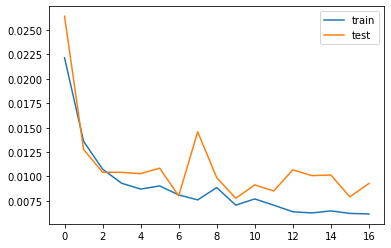

In [276]:
# plot history
pyplot.plot(history_2.history['loss'], label='train')
pyplot.plot(history_2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [277]:
import hydroeval as he

y_pred_2 = model_2.predict(X_test_scaled)

nse_2 = he.evaluator(he.nse,y_pred_2,y_test_scaled)
nse_2

array([0.7677759])

In [278]:
kge_2 = he.evaluator(he.kge, y_pred_2, y_test_scaled)
kge_2[0]

array([0.75343588])

### Selecting the proper length of sequence

In [98]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


def train_model(nb_days):
    X_train, y_train = get_X_y(df_train, 2000, nb_days) # 1000
    X_test, y_test = get_X_y(df_test, 731, nb_days) # 200

    # processing data
    X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
    X_train_ready = np.asarray(X_train_new)
    X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
    X_test_ready = np.asarray(X_test_new)

    # transforming input
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
    X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)

    # transforming output
    y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train_shaped)
    y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))
    y_test_scaled = scaler.transform(y_test_shaped)

    model = init_model_2() # second defined model above

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    model.fit(X_train_scaled, y_train_scaled,
                validation_data=(X_test_scaled, y_test_scaled),
                epochs=200,
                batch_size=32,
                callbacks=[es],
                verbose=1)

    res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
    return res


In [99]:
%%time
MSE_b = []

# a list of possible lag days that makes sense: can be modified
nb_days_full = [31, 61, 91, 121, 151, 181, 210]

for nb_days in nb_days_full:

    res = train_model(nb_days)
    MSE_b.append(res[0])

    print(f'For {nb_days} days of observation, the MSE is of {res[0]:.4f}')

Epoch 1/200
63/63 [==============================] - 11s 71ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 2/200
63/63 [==============================] - 2s 30ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 3/200
63/63 [==============================] - 2s 30ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 4/200
63/63 [==============================] - 2s 30ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 5/200
63/63 [==============================] - 2s 30ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 6/200
63/63 [==============================] - 2s 32ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 7/200
63/63 [==============================] - 3s 42ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 8/200
63/63 [==============================] - 2s 32ms/step - loss: 0

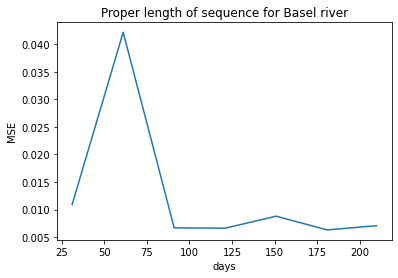

In [100]:
# Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision.
# Consider running the example a few times and compare the average outcome.
plt.plot(nb_days_full, MSE_b)
plt.title("Proper length of sequence for Basel river")
plt.xlabel('days')
plt.ylabel('MSE')
plt.show()

In [631]:
# first run 81
# second run 81
# third run 151
# fourth run 81
# fifth run 60 to 150 (=100)
# sixth run 80
# seventh run 181 >>>> so far mean = 136
# eghits run 180 but 121 also very close
#ninth run 90
# tenth run 120 and 180
# 11th 150
#12th run 90

# Lobith river

In [632]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import models
from tensorflow.keras import layers

In [633]:
df_l = pd.read_csv("lobith.csv", index_col=0)
df_l.tail()

,datetime,et,p,t,obs
7300,2000-12-27,0.000414,0.001720,2.381292,1925
7301,2000-12-28,0.000355,0.000932,-0.018737,1941
7302,2000-12-29,0.000318,0.000922,-1.723394,2123
7303,2000-12-30,0.000302,0.000462,-2.477089,2292
7304,2000-12-31,0.000287,0.000952,-3.375436,2255


In [634]:
df_l.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
et,7305.0,0.001813,0.001265,0.000106,0.000604,0.001578,0.002820,0.005944
p,7305.0,0.002575,0.003405,0.000000,0.000043,0.001207,0.003869,0.029550
t,7305.0,9.002240,7.177492,-17.833004,3.631933,9.177105,14.708690,26.345102
obs,7305.0,2359.275838,1246.986091,794.000000,1511.000000,2020.000000,2801.000000,11885.000000


In [635]:
q_lobith = pd.read_csv("q_lobith.csv")
#q_basel = q_basel.drop(["obs"], axis =1)
q_lobith = q_lobith.set_index("datetime")
q_lobith

,obs,pcr,res
datetime,,,
1981-01-01,2622,2213.4424,408.5576
1981-01-02,2496,2468.9614,27.0386
1981-01-03,2485,2960.4956,-475.4956
1981-01-04,2835,2895.0044,-60.0044
1981-01-05,3443,2805.3313,637.6687
...,...,...,...
2000-12-27,1925,2817.2803,-892.2803
2000-12-28,1941,2759.7256,-818.7256
2000-12-29,2123,2659.5396,-536.5396


In [636]:
# is it the right thing to do?
# shouldnot I make day and month vars with it?
df_lobith = df_l.set_index("datetime")
df_lobith.shape

(7305, 4)

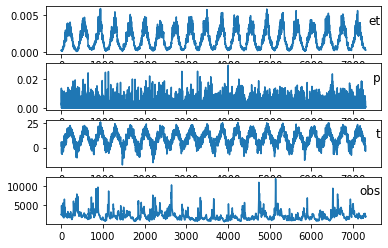

In [637]:
from matplotlib import pyplot

values = df_lobith.values

# specify columns to plot
groups =[0,1,2,3]
i=1
# plot each column
pyplot.figure()
for g in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, g])
    pyplot.title(df_lobith.columns[g], y= 0.5, loc ="right")
    i += 1
pyplot.show()



### LSTM data prepration

In [638]:
# a function that, given the initial dataframe, return a shorter dataframe sequence of length.
# This shorter sequence should be selected at random.
def subsample_sequence(df, length):

    last_possible = df.shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]

    return df_sample

In [639]:
# a function to deal with nan values
def fillna(X, df_mean):

    na = X.mean()

    na.fillna(df_mean)
    return na

# a function that given a full dataframe, first subsample this dataset into a shorter sequence,
# and then splits the shorter dataframe into a training sequence and a value to predict.

def split_subsample_sequence(df, length, df_mean=None):
    # Little trick to improve the time
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    if set(["pcr","res"]).issubset(df_subsample.columns):
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['pcr']
    else:
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['obs']

    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(df, length, df_mean)
        return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:df_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, df_mean))
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [640]:
# another function that generates an entire dataset of multiple subsamples,
# given an initial dataframe df, a number of desired sequences, and a length for each sequence

def get_X_y(df, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [641]:
# train test split
len_l = int(0.8*df_lobith.shape[0])

df_train_l = df_lobith[:len_l]
df_test_l = df_lobith[len_l:]

In [642]:
# time window has to be decided later but for now I keep it 50

X_train_l, y_train_l = get_X_y(df_train_l, 2000, 81) # The training set correspond to 1000 sequences, each of size 50 (+ the time to predict)
X_test_l, y_test_l = get_X_y(df_test_l, 731, 81)

# how to decide about number of sequence and time window?

In [643]:
print(X_train_l.shape,y_train_l.shape,X_test_l.shape,y_test_l.shape)

(2000, 80, 4) (2000,) (731, 80, 4) (731,)


In [644]:
X_train_l[0]  # drop column 4 for each array

array([[ 1.3678633e-03,  7.1058893e-03,  1.3268011e+01,  2.4470000e+03],
       [ 1.0317117e-03,  4.0397994e-04,  8.5395530e+00,  2.7390000e+03],
       [ 9.6371200e-04,  0.0000000e+00,  7.4772100e+00,  3.2350000e+03],
       [ 1.0124047e-03,  0.0000000e+00,  8.3902940e+00,  3.1480000e+03],
       [ 1.1475340e-03,  1.9469990e-04,  1.0586394e+01,  2.7810000e+03],
       [ 1.0829866e-03,  6.8604440e-04,  9.7360100e+00,  2.4840000e+03],
       [ 9.6083030e-04,  1.3839861e-03,  7.7969484e+00,  2.2310000e+03],
       [ 9.9601450e-04,  1.1377379e-03,  8.4847890e+00,  2.0420000e+03],
       [ 9.4825110e-04,  3.3025990e-03,  7.7176540e+00,  1.9520000e+03],
       [ 9.5916016e-04,  5.7026907e-04,  7.9699310e+00,  1.9730000e+03],
       [ 1.0428318e-03,  1.6836083e-04,  9.4791540e+00,  2.0330000e+03],
       [ 1.1231893e-03,  0.0000000e+00,  1.0850819e+01,  2.0120000e+03],
       [ 1.1208635e-03,  8.6481590e-04,  1.0911519e+01,  1.9360000e+03],
       [ 1.0615386e-03,  6.6848644e-03,  1.0078955e

In [645]:
y_train_l

array([2240., 2303., 1899., ..., 2424., 1886., 1858.])

In [646]:
# dropping "obs" var from predictors in train set
X_train_new_l = [np.delete(X,-1, axis =1) for X in X_train_l]
X_train_ready_l = np.asarray(X_train_new_l)
X_train_ready_l.shape

(2000, 80, 3)

In [647]:
# dropping "obs" var from predictors in test set
X_test_new_l = [np.delete(X,-1, axis = 1) for X in X_test_l]
X_test_ready_l = np.asarray(X_test_new_l)
X_test_ready_l.shape

(731, 80, 3)

### Normalize data

In [648]:
# https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled_l = scaler.fit_transform(X_train_ready_l.reshape(-1, X_train_ready_l.shape[-1])).reshape(X_train_ready_l.shape)
X_test_scaled_l = scaler.transform(X_test_ready_l.reshape(-1, X_test_ready_l.shape[-1])).reshape(X_test_ready_l.shape)

X_test_scaled_l[0]

array([[2.46331520e-01, 4.01960737e-04, 5.81125807e-01],
       [2.89299637e-01, 5.77710466e-03, 6.35627295e-01],
       [2.73714108e-01, 1.41049602e-02, 6.14326563e-01],
       [2.40405693e-01, 0.00000000e+00, 5.66837888e-01],
       [2.03142022e-01, 0.00000000e+00, 5.07417543e-01],
       [1.83824365e-01, 0.00000000e+00, 4.72747159e-01],
       [2.00645520e-01, 2.11452229e-02, 4.99551294e-01],
       [1.96403648e-01, 5.81739237e-02, 4.91545360e-01],
       [1.97352950e-01, 1.35621514e-02, 4.91476934e-01],
       [2.16320523e-01, 1.19991048e-01, 5.20667998e-01],
       [1.99315298e-01, 1.47268821e-01, 4.91476828e-01],
       [2.19737942e-01, 1.09696326e-01, 5.22004187e-01],
       [2.53289203e-01, 0.00000000e+00, 5.69848180e-01],
       [2.94384686e-01, 2.69755511e-02, 6.19277250e-01],
       [2.69164859e-01, 1.70820154e-01, 5.87172796e-01],
       [2.28747771e-01, 2.97725033e-01, 5.29108124e-01],
       [2.24675529e-01, 4.40736519e-02, 5.21194283e-01],
       [2.53006151e-01, 0.00000

In [649]:
# normalize output
y_train_shaped_l = np.reshape(y_train_l, (y_train_l.shape[0], 1))

scaler = MinMaxScaler()
y_train_scaled_l = scaler.fit_transform(y_train_shaped_l)
# y_train_scaled[0]

y_test_shaped_l = np.reshape(y_test_l, (y_test_l.shape[0], 1))

y_test_scaled_l = scaler.transform(y_test_shaped_l)
y_test_scaled_l.shape

(731, 1)

### Build the model

In [650]:
%%time
def init_model():

    model = models.Sequential()
    model.add(layers.LSTM(100, activation='relu', return_sequences=True)) # input shape?? input_shape =(X_train_scaled_l.shape[1],3)
    model.add(Dropout(0.2)) # decrease this
    model.add(layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(layers.LSTM(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1,activation='linear')) # activation = linear # maybe no need to y scaled : if I dont normalise it, I get very high val_mae


    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse']) # change this to mse

    return model

from tensorflow.keras.callbacks import EarlyStopping

model_l = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history = model_l.fit(X_train_scaled_l, y_train_scaled_l,
            validation_data=(X_test_scaled_l, y_test_scaled_l),
            epochs=1000,
            batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
            callbacks=[es])

Epoch 1/1000
63/63 [==============================] - 29s 398ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 2/1000
63/63 [==============================] - 25s 394ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 3/1000
63/63 [==============================] - 25s 393ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 4/1000
63/63 [==============================] - 24s 385ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 5/1000
63/63 [==============================] - 25s 395ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/1000
63/63 [==============================] - 25s 391ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 7/1000
63/63 [==============================] - 25s 390ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 8/1000
63/63 [==============================] - 2

In [651]:
print(model_l.input_shape, model_l.output_shape) # None is a placeholder of batch size

(None, 80, 3) (None, 1)


In [652]:
model_l.summary()

Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_314 (LSTM)             (None, 80, 100)           41600     
                                                                 
 dropout_60 (Dropout)        (None, 80, 100)           0         
                                                                 
 lstm_315 (LSTM)             (None, 80, 100)           80400     
                                                                 
 dropout_61 (Dropout)        (None, 80, 100)           0         
                                                                 
 lstm_316 (LSTM)             (None, 80, 100)           80400     
                                                                 
 dropout_62 (Dropout)        (None, 80, 100)           0         
                                                                 
 lstm_317 (LSTM)             (None, 100)            

In [653]:
res = model_l.evaluate(X_test_scaled_l, y_test_scaled_l, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}')

MAE on the test set : 0.0017


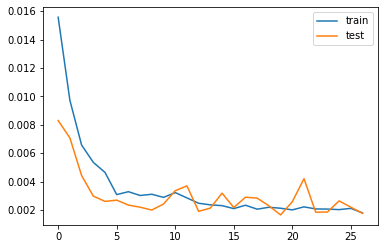

In [654]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [655]:
import hydroeval as he

y_pred_l = model_l.predict(X_test_scaled_l)

nse = he.evaluator(he.nse,y_pred_l,y_test_scaled_l)
nse[0]


0.8383744768976329

In [656]:
# why it gives me 4 results?
kge = he.evaluator(he.kge, y_pred_l, y_test_scaled_l)
kge[0]

array([0.88437532])

## Prediction

In [657]:
# https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

train_predict_l = model_l.predict(X_train_scaled_l)
test_predict_l = model_l.predict(X_test_scaled_l)

# invert predictions
train_predict_l = scaler.inverse_transform(train_predict_l)
Y_train_l = scaler.inverse_transform(y_train_scaled_l) # maybe inside []
test_predict_l = scaler.inverse_transform(test_predict_l)
Y_test_l = scaler.inverse_transform(y_test_scaled_l)


In [658]:
test_predict_l

array([[2726.6382],
       [1929.4005],
       [2220.0435],
       [1790.6511],
       [2127.4678],
       [4299.681 ],
       [1889.4666],
       [3764.494 ],
       [1846.2719],
       [2158.1875],
       [2017.0192],
       [1708.0984],
       [3492.8   ],
       [2047.2864],
       [1611.1549],
       [1287.507 ],
       [1516.7479],
       [2682.612 ],
       [3481.7053],
       [2102.2793],
       [1418.1804],
       [2285.7573],
       [1287.507 ],
       [1503.4608],
       [3708.1685],
       [4304.087 ],
       [1773.8619],
       [1317.4253],
       [1965.7118],
       [1287.507 ],
       [2889.6904],
       [1287.507 ],
       [2117.2588],
       [2015.7759],
       [1287.507 ],
       [1287.507 ],
       [1892.5522],
       [1541.4546],
       [1287.507 ],
       [4472.915 ],
       [4778.435 ],
       [1912.4573],
       [2242.51  ],
       [1860.0421],
       [2553.2573],
       [2817.051 ],
       [1393.6163],
       [1603.6166],
       [3492.8   ],
       [2981.8494],


## Plot

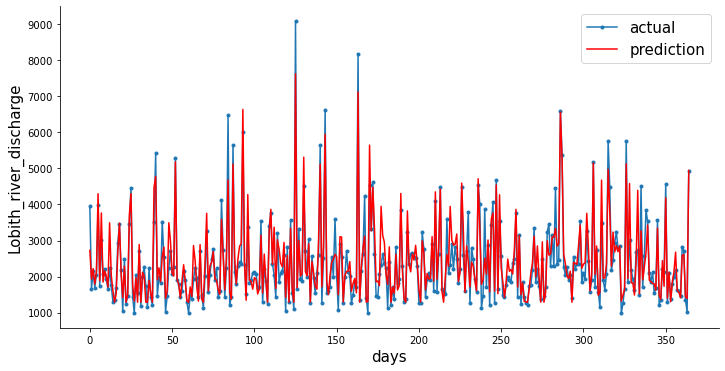

In [659]:
# comparing actual and predicted values for the last 356 days
import seaborn as sns

aa=[x for x in range(365)]
plt.figure(figsize=(10,5))
plt.plot(aa, Y_test_l[:365], marker='.', label="actual")
plt.plot(aa, test_predict_l[:,0][:365], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Lobith_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [660]:
# https://stackoverflow.com/questions/43702481/why-does-keras-lstm-batch-size-used-for-prediction-have-to-be-the-same-as-fittin :Why does Keras LSTM batch size used for prediction have to be the same as fitting batch size?

# getting the result of pcr model
pcr_pred = q_lobith.pcr.values

# train-test split
len_l = int(0.8*q_lobith.shape[0])

df_train_pcr = q_lobith[:len_l]
df_test_pcr = q_lobith[len_l:]

# making data in right shape
pcr_X_train, pcr_y_train = get_X_y(df_train_pcr, 2000, 151)
pcr_X_test, pcr_y_test = get_X_y(df_test_pcr, 731, 151)

# normalize pcr_observation
pcr_y_test_reshaped = np.reshape(pcr_y_test, (pcr_y_test.shape[0], 1))

scaler = MinMaxScaler()
pcr_y_test_scaled = scaler.fit_transform(pcr_y_test_reshaped)

# nse for pcr
nse_pcr = he.evaluator(he.nse, pcr_y_test_scaled, y_test_scaled_l)  # I am not sure I amdoing the right thing here
nse_pcr

array([-5.16684803])

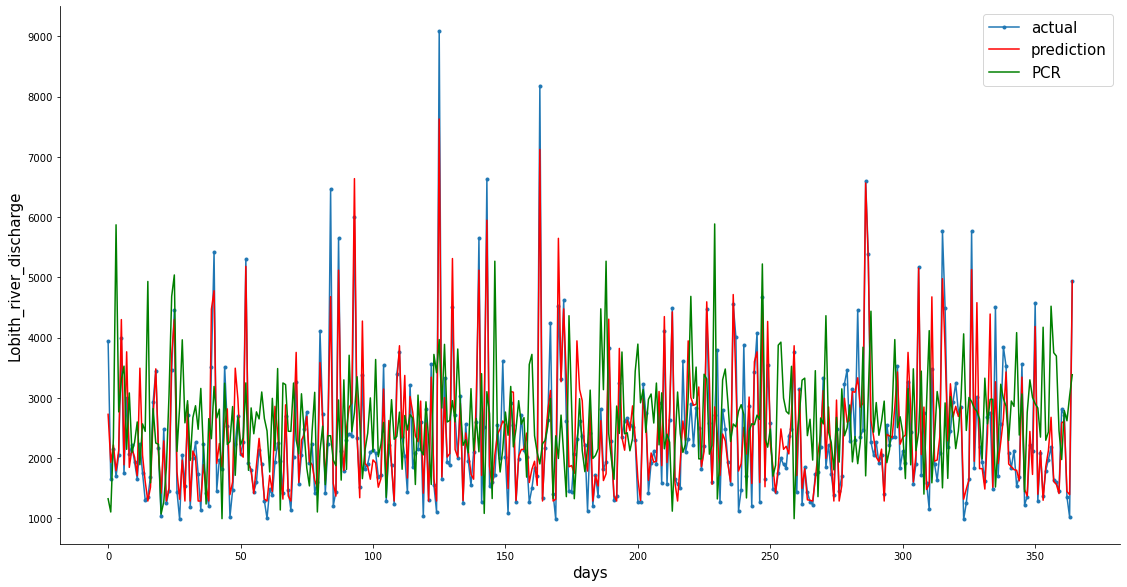

In [661]:
aa=[x for x in range(365)]
plt.figure(figsize=(16,8))
plt.plot(aa, Y_test_l[:365], marker='.', label="actual")
plt.plot(aa, test_predict_l[:,0][:365], 'r', label="prediction")
plt.plot(aa, pcr_y_test [:365], "green", label ="PCR" )
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Lobith_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [662]:
#define a smoothing function
def smooth_fun(y, window):
  new_len = len(y)//window
  smooth_y = np.zeros((new_len))
  for i in range(new_len):
    smooth_y[i] = np.mean(y[i*window:i*window+window])
  return smooth_y

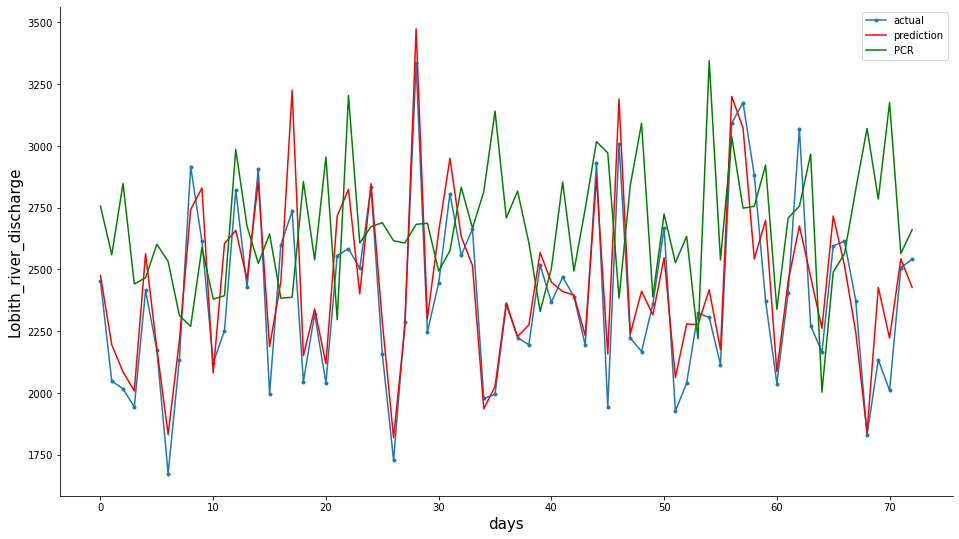

In [663]:
#plot smoothed predictions
plt.figure(figsize = (16,9))
plt.plot(smooth_fun(Y_test_l, 10), marker='.', label = "actual")
plt.plot(smooth_fun(test_predict_l, 10),"r", label = "prediction")
plt.plot(smooth_fun(pcr_y_test,10),"green", label = "PCR")
plt.ylabel('Lobith_river_discharge', size=15)
plt.xlabel('days', size=15)
sns.despine(top=True)

plt.legend()
plt.show()

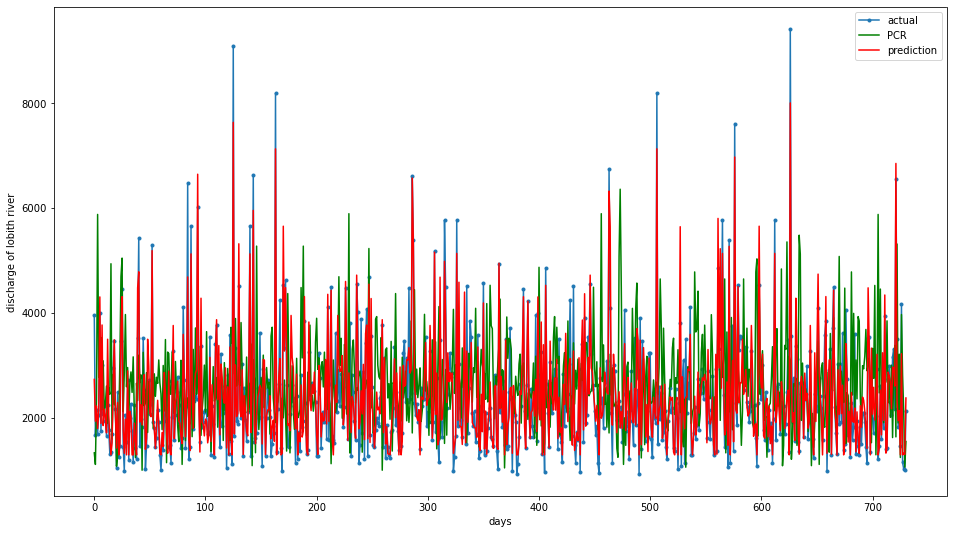

In [664]:
# make a plot of observed dicharge, prediction of model, prediction of pcr for the last 2 years
# plot it agianst date but you can take the last two years

# discharge_date = df_lobith['1999-01-01':'2000-12-31']
#
# discharge_observed = discharge_date.obs.values # shouldnot it be Y_test
#
# discharge_pcr_date = q_lobith['1999-01-01':'2000-12-31']
# discharge_pcr = discharge_pcr_date.pcr.values  # shouldnot it be pcr_y_test
# plt.figure(figsize=(16,9))
# plt.plot(discharge_observed, marker='.', label="actual")
# plt.plot(discharge_pcr, 'r', label="PCR")
# plt.plot(test_predict_l, 'green', label="prediction")
# plt.xlabel('days')
# plt.ylabel('discharge of lobith river')
# plt.legend()



plt.figure(figsize=(16,9))
plt.plot(Y_test_l[:731], marker='.', label="actual")
plt.plot(pcr_y_test [:731], 'green', label="PCR")
plt.plot(test_predict_l, 'r', label="prediction")
plt.xlabel('days')
plt.ylabel('discharge of lobith river')
plt.legend()

In [665]:
test_predict_l

array([[2726.6382],
       [1929.4005],
       [2220.0435],
       [1790.6511],
       [2127.4678],
       [4299.681 ],
       [1889.4666],
       [3764.494 ],
       [1846.2719],
       [2158.1875],
       [2017.0192],
       [1708.0984],
       [3492.8   ],
       [2047.2864],
       [1611.1549],
       [1287.507 ],
       [1516.7479],
       [2682.612 ],
       [3481.7053],
       [2102.2793],
       [1418.1804],
       [2285.7573],
       [1287.507 ],
       [1503.4608],
       [3708.1685],
       [4304.087 ],
       [1773.8619],
       [1317.4253],
       [1965.7118],
       [1287.507 ],
       [2889.6904],
       [1287.507 ],
       [2117.2588],
       [2015.7759],
       [1287.507 ],
       [1287.507 ],
       [1892.5522],
       [1541.4546],
       [1287.507 ],
       [4472.915 ],
       [4778.435 ],
       [1912.4573],
       [2242.51  ],
       [1860.0421],
       [2553.2573],
       [2817.051 ],
       [1393.6163],
       [1603.6166],
       [3492.8   ],
       [2981.8494],


In [666]:
%%time
from tensorflow.keras.callbacks import EarlyStopping

def init_model_2():

    model = models.Sequential()
    model.add(layers.LSTM(50, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(50, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1,activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'])

    return model

model_2_l = init_model_2()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history_2 = model_2_l.fit(X_train_scaled_l, y_train_scaled_l,
            validation_data=(X_test_scaled_l, y_test_scaled_l),   # you can also have validation_split
            epochs=1000,
            batch_size=32,
            callbacks=[es])


Epoch 1/1000
63/63 [==============================] - 17s 191ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 2/1000
63/63 [==============================] - 12s 185ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/1000
63/63 [==============================] - 10s 154ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/1000
63/63 [==============================] - 10s 162ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 5/1000
63/63 [==============================] - 10s 155ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/1000
63/63 [==============================] - 10s 157ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/1000
63/63 [==============================] - 10s 163ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/1000
63/63 [==============================] - 1

In [667]:
model_2_l.summary()

Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_318 (LSTM)             (None, 80, 50)            10800     
                                                                 
 lstm_319 (LSTM)             (None, 50)                20200     
                                                                 
 dense_286 (Dense)           (None, 5)                 255       
                                                                 
 dense_287 (Dense)           (None, 1)                 6         
                                                                 
Total params: 31,261
Trainable params: 31,261
Non-trainable params: 0
_________________________________________________________________


In [668]:
# I get a better result with a simpler network with batch size of 32 0.0575
res = model_2_l.evaluate(X_test_scaled_l, y_test_scaled_l, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0017


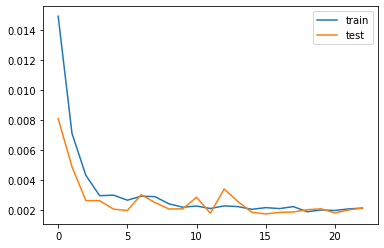

In [669]:
# plot history
pyplot.plot(history_2.history['loss'], label='train')
pyplot.plot(history_2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [670]:
import hydroeval as he

y_pred_2_l = model_2_l.predict(X_test_scaled_l)

nse_2 = he.evaluator(he.nse,y_pred_2_l,y_test_scaled_l)
nse_2

array([0.83068953])

In [671]:
kge_2 = he.evaluator(he.kge, y_pred_2_l, y_test_scaled_l)
kge_2[0]

array([0.85177189])

### Selecting the proper length of sequence

In [672]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


def train_model(nb_days):
    X_train, y_train = get_X_y(df_train_l, 1000, nb_days)
    X_test, y_test = get_X_y(df_test_l, 731, nb_days)

    # processing data
    X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
    X_train_ready = np.asarray(X_train_new)
    X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
    X_test_ready = np.asarray(X_test_new)

    # transforming input
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
    X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)

    # transforming output
    y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train_shaped)
    y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))
    y_test_scaled = scaler.transform(y_test_shaped)

    model = init_model_2() # second defined model above

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    model.fit(X_train_scaled, y_train_scaled,
                validation_data=(X_test_scaled, y_test_scaled),
                epochs=200,
                batch_size=32,
                callbacks=[es],
                verbose=1)

    res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
    return res


In [673]:
%%time
MSE_l = []

# a list of possible lag days that makes sense: can be modified
nb_days_full = [31, 61, 91, 121, 151, 181, 211, 241, 271]

for nb_days in nb_days_full:

    res = train_model(nb_days)
    MSE_l.append(res[0])

    print(f'For {nb_days} days of observation, the MSE is of {res[0]:.4f}')

Epoch 1/200
32/32 [==============================] - 21s 128ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 2/200
32/32 [==============================] - 2s 70ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 3/200
32/32 [==============================] - 3s 79ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 4/200
32/32 [==============================] - 2s 69ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 5/200
32/32 [==============================] - 2s 76ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 6/200
32/32 [==============================] - 3s 82ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/200
32/32 [==============================] - 2s 74ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 8/200
32/32 [==============================] - 2s 72ms/step - loss: 

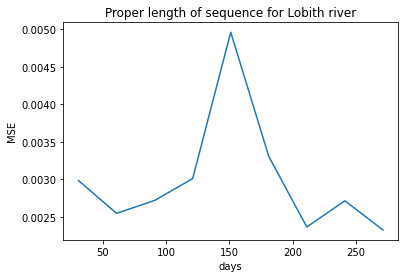

In [674]:
# Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision.
# Consider running the example a few times and compare the average outcome.

plt.plot(nb_days_full, MSE_l)
plt.title("Proper length of sequence for Lobith river")
plt.xlabel('days')
plt.ylabel('MSE')
plt.show()

# this variation makes choosing the numeber of sequence very difficult

In [536]:
# first run 81 and 181
# second run 81 to 125 and 181 to 210
### adding days 240 and 270 to the list of sequence ###
# third run 61 to 151 and 181 to 211
# fourth run 61 to 81 days and 210 days
# fifth run 120 and 240
# sixth run 60 and 210
# seventh run

# Cochem river

In [537]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import models
from tensorflow.keras import layers

In [538]:
df_c = pd.read_csv("cochem.csv", index_col=0)
df_c.tail()

,datetime,et,p,t,obs
7300,2000-12-27,0.000508,0.002704,3.777371,678.0
7301,2000-12-28,0.000427,0.002854,0.914861,819.0
7302,2000-12-29,0.000384,0.001209,-0.888285,727.0
7303,2000-12-30,0.000369,0.000165,-1.371431,602.0
7304,2000-12-31,0.000379,0.003271,-0.934144,531.0


In [539]:
df_c.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
et,7305.0,0.001895,0.001346,0.000030,0.000613,0.001654,0.002951,0.006381
p,7305.0,0.002375,0.003786,0.000000,0.000000,0.000531,0.003393,0.032706
t,7305.0,9.731976,7.091541,-16.372622,4.555471,9.927507,15.275904,27.175457
obs,7305.0,363.516044,393.030918,37.400000,126.000000,226.000000,441.000000,4020.000000


In [540]:
q_cochem = pd.read_csv("q_cochem.csv")
#q_basel = q_basel.drop(["obs"], axis =1)
q_cochem = q_cochem.set_index("datetime")
q_cochem

,obs,pcr,res
datetime,,,
1981-01-01,425.0,444.64508,-19.64508
1981-01-02,421.0,484.39390,-63.39390
1981-01-03,496.0,580.79660,-84.79660
1981-01-04,1060.0,706.42320,353.57680
1981-01-05,1430.0,707.54596,722.45404
...,...,...,...
2000-12-27,678.0,585.63495,92.36505
2000-12-28,819.0,574.72700,244.27300
2000-12-29,727.0,571.79780,155.20220


In [541]:
# is it the right thing to do?
# shouldnot I make day and month vars with it?
df_cochem = df_c.set_index("datetime")
df_cochem.shape

(7305, 4)

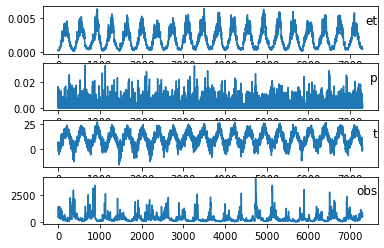

In [542]:
from matplotlib import pyplot

values = df_cochem.values

# specify columns to plot
groups =[0,1,2,3]
i=1
# plot each column
pyplot.figure()
for g in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, g])
    pyplot.title(df_cochem.columns[g], y= 0.5, loc ="right")
    i += 1
pyplot.show()



### LSTM data prepration

In [543]:
# a function that, given the initial dataframe, return a shorter dataframe sequence of length.
# This shorter sequence should be selected at random.
def subsample_sequence(df, length):

    last_possible = df.shape[0] - length

    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]

    return df_sample

In [544]:
# a function to deal with nan values
def fillna(X, df_mean):

    na = X.mean()

    na.fillna(df_mean)
    return na

# a function that given a full dataframe, first subsample this dataset into a shorter sequence,
# and then splits the shorter dataframe into a training sequence and a value to predict.

def split_subsample_sequence(df, length, df_mean=None):
    # Little trick to improve the time
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    if set(["pcr","res"]).issubset(df_subsample.columns):
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['pcr']
    else:
        y_sample = df_subsample.iloc[df_subsample.shape[0]-1]['obs']

    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(df, length, df_mean)
        return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:df_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, df_mean))
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [545]:
# another function that generates an entire dataset of multiple subsamples,
# given an initial dataframe df, a number of desired sequences, and a length for each sequence

def get_X_y(df, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [546]:
# train test split
len_c = int(0.8*df_cochem.shape[0])

df_train_c = df_cochem[:len_c]
df_test_c = df_cochem[len_c:]

In [547]:
# time window has to be decided later but for now I keep it 50

X_train_c, y_train_c = get_X_y(df_train_c, 2000, 61) # The training set correspond to 1000 sequences, each of size 50 (+ the time to predict)
X_test_c, y_test_c = get_X_y(df_test_c, 731, 61)

# how to decide about number of sequence and time window?

In [548]:
print(X_train_c.shape,y_train_c.shape,X_test_c.shape,y_test_c.shape)

(2000, 60, 4) (2000,) (731, 60, 4) (731,)


In [549]:
X_train_c[0]  # drop column 4 for each array

array([[1.2218294e-03, 0.0000000e+00, 1.4451339e+01, 1.1700000e+02],
       [1.2051945e-03, 0.0000000e+00, 1.4304801e+01, 1.1100000e+02],
       [1.0810952e-03, 3.9742645e-03, 1.2548645e+01, 1.1600000e+02],
       [9.0690770e-04, 1.8639882e-03, 9.6674230e+00, 1.2300000e+02],
       [9.0679500e-04, 3.2706104e-02, 9.7406090e+00, 1.2500000e+02],
       [8.9265620e-04, 3.1049151e-02, 9.5815090e+00, 1.6200000e+02],
       [8.9739480e-04, 7.3819817e-03, 9.7528490e+00, 5.8600000e+02],
       [8.5219330e-04, 3.2954253e-03, 8.9754550e+00, 6.6400000e+02],
       [8.9724717e-04, 4.7752177e-03, 9.9322100e+00, 5.0900000e+02],
       [8.8897144e-04, 8.8596640e-03, 9.8644495e+00, 4.0800000e+02],
       [9.0096943e-04, 1.0284943e-02, 1.0175639e+01, 4.7500000e+02],
       [9.4237976e-04, 1.1791979e-02, 1.1021275e+01, 6.2900000e+02],
       [8.5603340e-04, 5.1276884e-03, 9.4896460e+00, 8.9900000e+02],
       [7.6819860e-04, 2.1305277e-04, 7.7633786e+00, 1.3500000e+03],
       [8.2328910e-04, 4.1213497e-

In [550]:
y_train_c

array([462., 117., 232., ..., 997., 605., 118.])

In [551]:
# dropping "obs" var from predictors in train set
X_train_new_c = [np.delete(X,-1, axis =1) for X in X_train_c]
X_train_ready_c = np.asarray(X_train_new_c)
X_train_ready_c.shape

(2000, 60, 3)

In [552]:
# dropping "obs" var from predictors in test set
X_test_new_c = [np.delete(X,-1, axis = 1) for X in X_test_c]
X_test_ready_c = np.asarray(X_test_new_c)
X_test_ready_c.shape

(731, 60, 3)

### Normalize data

In [553]:
# https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled_c = scaler.fit_transform(X_train_ready_c.reshape(-1, X_train_ready_c.shape[-1])).reshape(X_train_ready_c.shape)
X_test_scaled_c = scaler.transform(X_test_ready_c.reshape(-1, X_test_ready_c.shape[-1])).reshape(X_test_ready_c.shape)

X_test_scaled_c[0]

array([[0.12382477, 0.51526143, 0.54886035],
       [0.11512458, 0.06151159, 0.51895727],
       [0.10593234, 0.25585229, 0.48697952],
       [0.09187621, 0.14057261, 0.43379081],
       [0.09086704, 0.0804585 , 0.42825915],
       [0.0815999 , 0.02637075, 0.39127007],
       [0.08916568, 0.        , 0.41856064],
       [0.10932849, 0.        , 0.48928433],
       [0.13147084, 0.07979177, 0.55478437],
       [0.12360677, 0.01389478, 0.53042627],
       [0.22973267, 0.26614466, 0.56978541],
       [0.2368333 , 0.12511582, 0.5792123 ],
       [0.22383554, 0.23447691, 0.55591125],
       [0.19058274, 0.05661414, 0.49399945],
       [0.17792278, 0.14369116, 0.46667102],
       [0.16926981, 0.06818363, 0.44637581],
       [0.16958562, 0.08805309, 0.4451771 ],
       [0.1978804 , 0.28504801, 0.50016531],
       [0.21762286, 0.11782065, 0.53347778],
       [0.20885399, 0.19975896, 0.51513597],
       [0.20829321, 0.10948499, 0.51322069],
       [0.26831372, 0.        , 0.60635928],
       [0.

In [554]:
# normalize output
y_train_shaped_c = np.reshape(y_train_c, (y_train_c.shape[0], 1))

scaler = MinMaxScaler()
y_train_scaled_c = scaler.fit_transform(y_train_shaped_c)
# y_train_scaled[0]

y_test_shaped_c = np.reshape(y_test_c, (y_test_c.shape[0], 1))

y_test_scaled_c = scaler.transform(y_test_shaped_c)
y_test_scaled_c.shape

(731, 1)

### Build the model

In [555]:
%%time
def init_model():

    model = models.Sequential()
    model.add(layers.LSTM(100, activation='relu', return_sequences=True)) # input shape?? input_shape =(X_train_scaled_c.shape[1],3)
    model.add(Dropout(0.2)) # decrease this
    model.add(layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(layers.LSTM(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1,activation='linear')) # activation = linear # maybe no need to y scaled : if I dont normalise it, I get very high val_mae


    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse']) # change this to mse

    return model

from tensorflow.keras.callbacks import EarlyStopping

model_c = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history = model_c.fit(X_train_scaled_c, y_train_scaled_c,
            validation_data=(X_test_scaled_c, y_test_scaled_c),
            epochs=1000,
            batch_size= 32, # try it with 16| 128 = 0.0687 | 512 = 0.705
            callbacks=[es])

Epoch 1/1000
63/63 [==============================] - 27s 365ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 2/1000
63/63 [==============================] - 21s 332ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 3/1000
63/63 [==============================] - 21s 335ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 4/1000
63/63 [==============================] - 20s 326ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 5/1000
63/63 [==============================] - 21s 326ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 6/1000
63/63 [==============================] - 21s 326ms/step - loss: 0.0673 - mse: 0.0673 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 7/1000
63/63 [==============================] - 21s 330ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 8/1000
63/63 [==============================] - 2

In [556]:
print(model_c.input_shape, model_c.output_shape) # None is a placeholder of batch size

(None, 60, 3) (None, 1)


In [557]:
model_c.summary()

Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_274 (LSTM)             (None, 60, 100)           41600     
                                                                 
 dropout_52 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_275 (LSTM)             (None, 60, 100)           80400     
                                                                 
 dropout_53 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_276 (LSTM)             (None, 60, 100)           80400     
                                                                 
 dropout_54 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_277 (LSTM)             (None, 100)            

In [558]:
res = model_c.evaluate(X_test_scaled_c, y_test_scaled_c, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0016


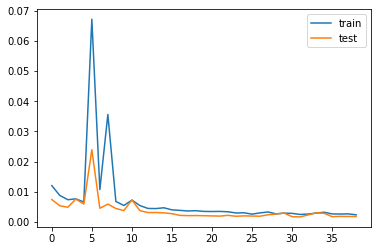

In [559]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [560]:
import hydroeval as he

y_pred_c = model_c.predict(X_test_scaled_c)

nse = he.evaluator(he.nse,y_pred_c,y_test_scaled_c)
nse[0]


0.8405488056209605

In [561]:
# why it gives me 4 results?
kge = he.evaluator(he.kge, y_pred_c, y_test_scaled_c)
kge[0]

array([0.88584966])

## Prediction

In [562]:
# https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

train_predict_c = model_c.predict(X_train_scaled_c)
test_predict_c = model_c.predict(X_test_scaled_c)

# invert predictions
train_predict_c = scaler.inverse_transform(train_predict_c)
Y_train_c = scaler.inverse_transform(y_train_scaled_c) # maybe inside []
test_predict_c = scaler.inverse_transform(test_predict_c)
Y_test_c = scaler.inverse_transform(y_test_scaled_c)


In [563]:
test_predict_c

array([[ 379.61133 ],
       [ 166.98947 ],
       [ 211.82506 ],
       [ 616.62006 ],
       [1018.2293  ],
       [ 118.41421 ],
       [ 118.41421 ],
       [ 143.03053 ],
       [ 228.69585 ],
       [ 349.35175 ],
       [ 466.94675 ],
       [ 265.5006  ],
       [ 454.10242 ],
       [ 988.97754 ],
       [ 298.14792 ],
       [ 118.41421 ],
       [1180.1416  ],
       [ 118.41421 ],
       [ 118.41421 ],
       [ 209.40536 ],
       [ 118.41421 ],
       [1178.5505  ],
       [ 163.43323 ],
       [ 602.3668  ],
       [ 211.80275 ],
       [ 558.0271  ],
       [ 245.72049 ],
       [ 118.41421 ],
       [ 172.98262 ],
       [ 436.7977  ],
       [ 574.94794 ],
       [ 422.48578 ],
       [ 272.08527 ],
       [ 614.8526  ],
       [ 118.41421 ],
       [ 118.41421 ],
       [ 311.85788 ],
       [1127.2666  ],
       [ 118.41421 ],
       [ 120.7968  ],
       [ 312.6093  ],
       [ 118.41421 ],
       [ 530.5043  ],
       [ 286.84668 ],
       [ 192.6181  ],
       [ 1

## Plot

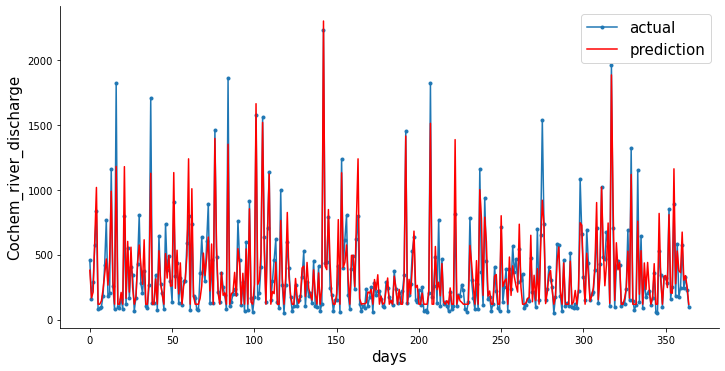

In [564]:
# comparing actual and predicted values for the last 356 days
import seaborn as sns

aa=[x for x in range(365)]
plt.figure(figsize=(10,5))
plt.plot(aa, Y_test_c[:365], marker='.', label="actual")
plt.plot(aa, test_predict_c[:,0][:365], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Cochem_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [565]:
# https://stackoverflow.com/questions/43702481/why-does-keras-lstm-batch-size-used-for-prediction-have-to-be-the-same-as-fittin :Why does Keras LSTM batch size used for prediction have to be the same as fitting batch size?

# getting the result of pcr model
# pcr_pred_c = q_cochem.pcr.values

# train-test split
len_c = int(0.8*q_cochem.shape[0])

df_train_pcr = q_cochem[:len_c]
df_test_pcr = q_cochem[len_c:]

# making data in right shape
pcr_X_train, pcr_y_train = get_X_y(df_train_pcr, 2000, 151)
pcr_X_test, pcr_y_test = get_X_y(df_test_pcr, 731, 151)

# normalize pcr_observation
pcr_y_test_reshaped = np.reshape(pcr_y_test, (pcr_y_test.shape[0], 1))

scaler = MinMaxScaler()
pcr_y_test_scaled = scaler.fit_transform(pcr_y_test_reshaped)

# nse for pcr
nse_pcr = he.evaluator(he.nse, pcr_y_test_scaled, y_test_scaled_c)  # I am not sure I am doing the right thing here
nse_pcr

array([-2.66974141])

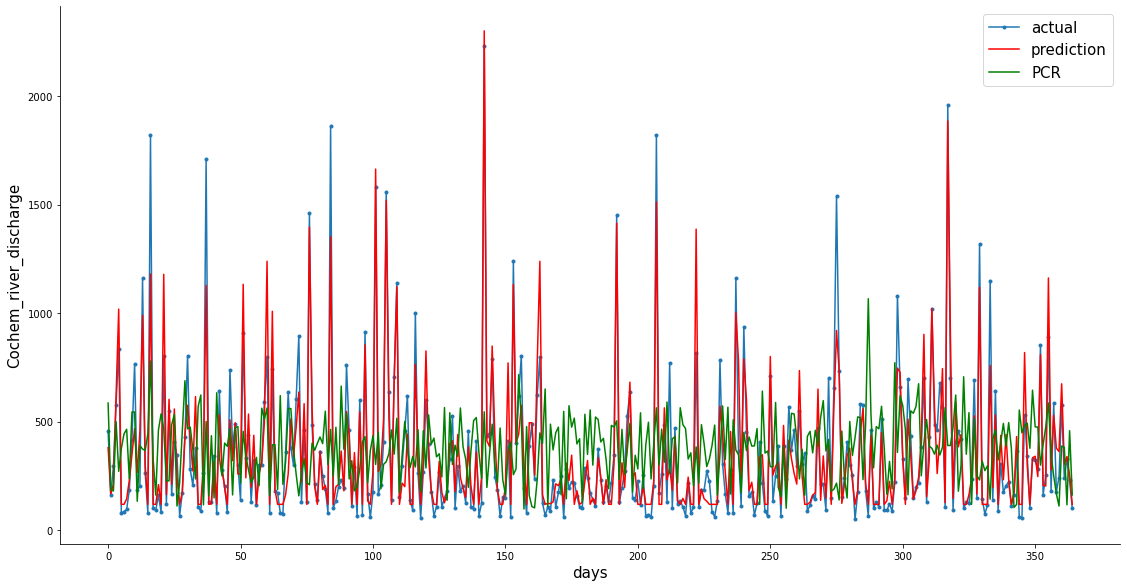

In [566]:
aa=[x for x in range(365)]
plt.figure(figsize=(16,8))
plt.plot(aa, Y_test_c[:365], marker='.', label="actual")
plt.plot(aa, test_predict_c[:,0][:365], "r", label="prediction")
plt.plot(aa, pcr_y_test [:365], "g",label ="PCR" )
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Cochem_river_discharge', size=15)
plt.xlabel('days', size=15)
plt.legend(fontsize=15)
plt.show();

In [567]:
#define a smoothing function
def smooth_fun(y, window):
  new_len = len(y)//window
  smooth_y = np.zeros((new_len))
  for i in range(new_len):
    smooth_y[i] = np.mean(y[i*window:i*window+window])
  return smooth_y

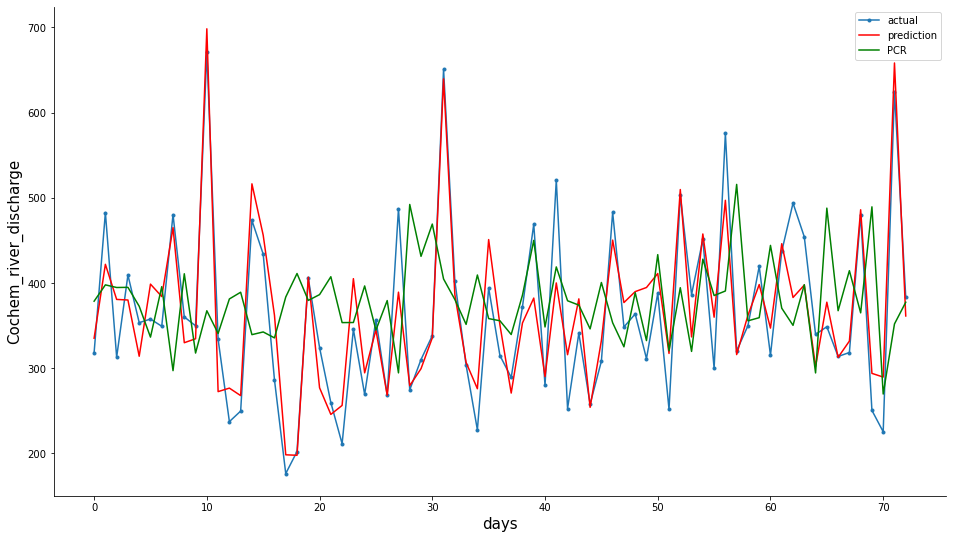

In [568]:
#plot smoothed predictions
plt.figure(figsize = (16,9))

plt.plot(smooth_fun(Y_test_c, 10), marker='.', label = "actual")
plt.plot(smooth_fun(test_predict_c, 10),"r", label = "prediction")
plt.plot(smooth_fun(pcr_y_test,10), "g", label = "PCR")
plt.ylabel('Cochem_river_discharge', size=15)
plt.xlabel('days', size=15)
sns.despine(top=True)

plt.legend()
plt.show()

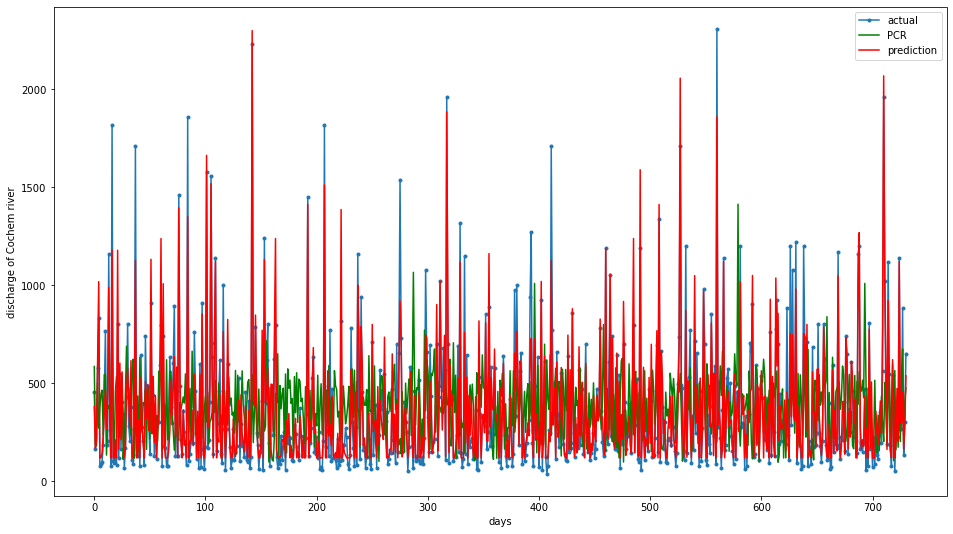

In [569]:
# make a plot of observed dicharge, prediction of model, prediction of pcr for the last 2 years
# plot it agianst date but you can take the last two years

# discharge_date = df_lobith['1999-01-01':'2000-12-31']
#
# discharge_observed = discharge_date.obs.values # shouldnot it be Y_test
#
# discharge_pcr_date = q_lobith['1999-01-01':'2000-12-31']
# discharge_pcr = discharge_pcr_date.pcr.values  # shouldnot it be pcr_y_test
# plt.figure(figsize=(16,9))
# plt.plot(discharge_observed, marker='.', label="actual")
# plt.plot(discharge_pcr, 'r', label="PCR")
# plt.plot(test_predict_l, 'green', label="prediction")
# plt.xlabel('days')
# plt.ylabel('discharge of lobith river')
# plt.legend()



plt.figure(figsize=(16,9))
plt.plot(Y_test_c[:731], marker='.', label="actual")
plt.plot(pcr_y_test [:731], 'green', label="PCR")
plt.plot(test_predict_c, 'r', label="prediction")
sns.despine(top=True)
plt.xlabel('days')
plt.ylabel('discharge of Cochem river')
plt.legend()

In [570]:
test_predict_c

array([[ 379.61133 ],
       [ 166.98947 ],
       [ 211.82506 ],
       [ 616.62006 ],
       [1018.2293  ],
       [ 118.41421 ],
       [ 118.41421 ],
       [ 143.03053 ],
       [ 228.69585 ],
       [ 349.35175 ],
       [ 466.94675 ],
       [ 265.5006  ],
       [ 454.10242 ],
       [ 988.97754 ],
       [ 298.14792 ],
       [ 118.41421 ],
       [1180.1416  ],
       [ 118.41421 ],
       [ 118.41421 ],
       [ 209.40536 ],
       [ 118.41421 ],
       [1178.5505  ],
       [ 163.43323 ],
       [ 602.3668  ],
       [ 211.80275 ],
       [ 558.0271  ],
       [ 245.72049 ],
       [ 118.41421 ],
       [ 172.98262 ],
       [ 436.7977  ],
       [ 574.94794 ],
       [ 422.48578 ],
       [ 272.08527 ],
       [ 614.8526  ],
       [ 118.41421 ],
       [ 118.41421 ],
       [ 311.85788 ],
       [1127.2666  ],
       [ 118.41421 ],
       [ 120.7968  ],
       [ 312.6093  ],
       [ 118.41421 ],
       [ 530.5043  ],
       [ 286.84668 ],
       [ 192.6181  ],
       [ 1

In [571]:
%%time
from tensorflow.keras.callbacks import EarlyStopping

def init_model_2():

    model = models.Sequential()
    model.add(layers.LSTM(50, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(50, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1,activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'])

    return model

model_2_c = init_model_2()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

history_2 = model_2_c.fit(X_train_scaled_c, y_train_scaled_c,
            validation_data=(X_test_scaled_c, y_test_scaled_c),   # you can also have validation_split
            epochs=1000,
            batch_size=32,
            callbacks=[es])


Epoch 1/1000
63/63 [==============================] - 10s 109ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 2/1000
63/63 [==============================] - 6s 101ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 3/1000
63/63 [==============================] - 6s 101ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 4/1000
63/63 [==============================] - 7s 107ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 5/1000
63/63 [==============================] - 6s 102ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/1000
63/63 [==============================] - 6s 101ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/1000
63/63 [==============================] - 6s 101ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 8/1000
63/63 [==============================] - 6s 101m

In [572]:
model_2_c.summary()

Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_278 (LSTM)             (None, 60, 50)            10800     
                                                                 
 lstm_279 (LSTM)             (None, 50)                20200     
                                                                 
 dense_250 (Dense)           (None, 5)                 255       
                                                                 
 dense_251 (Dense)           (None, 1)                 6         
                                                                 
Total params: 31,261
Trainable params: 31,261
Non-trainable params: 0
_________________________________________________________________


In [573]:
# I get a better result with a simpler network with batch size of 32 0.0575
res = model_2_c.evaluate(X_test_scaled_c, y_test_scaled_c, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0015


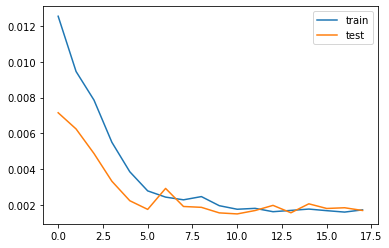

In [574]:
# plot history
pyplot.plot(history_2.history['loss'], label='train')
pyplot.plot(history_2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [575]:
import hydroeval as he

y_pred_2_c = model_2_c.predict(X_test_scaled_c)

nse_2 = he.evaluator(he.nse,y_pred_2_c,y_test_scaled_c)
nse_2

array([0.85058765])

In [576]:
kge_2 = he.evaluator(he.kge, y_pred_2_c, y_test_scaled_c)
kge_2[0]

array([0.85183839])

### Selecting the proper length of sequence

In [577]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


def train_model(nb_days):
    X_train, y_train = get_X_y(df_train_c, 1000, nb_days)
    X_test, y_test = get_X_y(df_test_c, 731, nb_days)

    # processing data
    X_train_new = [np.delete(X,-1, axis =1) for X in X_train]
    X_train_ready = np.asarray(X_train_new)
    X_test_new = [np.delete(X,-1, axis = 1) for X in X_test]
    X_test_ready = np.asarray(X_test_new)

    # transforming input
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_ready.reshape(-1, X_train_ready.shape[-1])).reshape(X_train_ready.shape)
    X_test_scaled = scaler.transform(X_test_ready.reshape(-1, X_test_ready.shape[-1])).reshape(X_test_ready.shape)

    # transforming output
    y_train_shaped = np.reshape(y_train, (y_train.shape[0], 1))
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train_shaped)
    y_test_shaped = np.reshape(y_test, (y_test.shape[0], 1))
    y_test_scaled = scaler.transform(y_test_shaped)

    model = init_model_2() # second defined model above

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    model.fit(X_train_scaled, y_train_scaled,
                validation_data=(X_test_scaled, y_test_scaled),
                epochs=200,
                batch_size=32,
                callbacks=[es],
                verbose=1)

    res = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
    return res


In [578]:
%%time
MSE_c = []

# a list of possible lag days that makes sense: can be modified
nb_days_full = [31, 61, 91, 121, 151, 181, 210]

for nb_days in nb_days_full:

    res = train_model(nb_days)
    MSE_c.append(res[0])

    print(f'For {nb_days} days of observation, the MSE is of {res[0]:.4f}')

Epoch 1/200
32/32 [==============================] - 10s 77ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 2/200
32/32 [==============================] - 2s 52ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 3/200
32/32 [==============================] - 2s 56ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 4/200
32/32 [==============================] - 2s 56ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 5/200
32/32 [==============================] - 2s 55ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/200
32/32 [==============================] - 2s 55ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 7/200
32/32 [==============================] - 2s 56ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 8/200
32/32 [==============================] - 2s 55ms/step - loss: 0

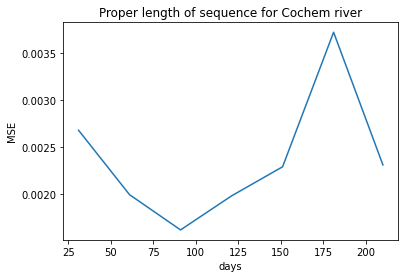

In [579]:
# Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.
plt.plot(nb_days_full, MSE_c)
plt.title("Proper length of sequence for Cochem river")
plt.xlabel('days')
plt.ylabel('MSE')
plt.show()

In [580]:
# first run 100 to 200 note that mse is very low in this range # long training should be taken into account, so it is better for opting for shorter period
# second run 60 to 200 (but 120 to 200 is the lowest)
# third run 60 to 220 (150 to 220 length of sequence are the lowest)
# fourth run 60 to 80
# fifth run
# sixth run
# seventh run